In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

sns.set(context="paper", style="whitegrid", 
       rc={
           "figure.figsize": (8, 5),
           "figure.dpi": 100
       })
google = ["#4285F4", "#DB4437", "#F4B400", "#0F9D58"]

sns.set_palette(google)

from preprocess_lib import preprocess_df, preprocess_timeseries

seed_ = 20200218
np.random.seed(seed_)

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Lambda, Conv1D
from keras.optimizers import *
tf.random.set_seed(seed_)
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Idea

- forecast main meter `active power` from previous data

## Problem

- เหมือนมันทำ regression
- คาดว่าเพราะข้อมูลไม่ได้มี period ที่แน่นอน?
- หรือเพราะข้อมูลที่เป็น step? อยู่ๆก็พุ่งขึ้น?

#### constant

number of minute in one day and one week

In [2]:
ONEDAY_MIN = 24*60
ONEWEEK_MIN = ONEDAY_MIN*7

In [3]:
ONEDAY_MIN, ONEWEEK_MIN

(1440, 10080)

## Load Meter Data

### explore the dataframe

In [4]:
df = pd.read_csv("./data/raw_appliances/main_1.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   TIMESTAMP              1051200 non-null  object 
 1   power factor_apparent  1051200 non-null  float64
 2   power_reactive         1051200 non-null  float64
 3   power_active           1051200 non-null  float64
 4   power_apparent         1051200 non-null  float64
 5   appliances_type        1051200 non-null  object 
 6   appliances_id          1051200 non-null  int64  
 7   appliances_name        1051200 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 64.2+ MB


In [6]:
df.head()

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_type,appliances_id,appliances_name
0,2012-04-01 00:00:00,0.93,141.0,918.0,1066.0,main,1,main 1
1,2012-04-01 00:01:00,0.93,141.0,913.0,1056.0,main,1,main 1
2,2012-04-01 00:02:00,0.93,139.0,872.0,1021.0,main,1,main 1
3,2012-04-01 00:03:00,0.93,141.0,872.0,1018.0,main,1,main 1
4,2012-04-01 00:04:00,0.89,140.0,772.0,1018.0,main,1,main 1


#### column variable

In [7]:
timestamp_col = "TIMESTAMP"

### Preprocess data frame

#### convert timestamp to datetime obj

In [8]:
preprocess_df.col_to_datetime(df, timestamp_col)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   TIMESTAMP              1051200 non-null  datetime64[ns]
 1   power factor_apparent  1051200 non-null  float64       
 2   power_reactive         1051200 non-null  float64       
 3   power_active           1051200 non-null  float64       
 4   power_apparent         1051200 non-null  float64       
 5   appliances_type        1051200 non-null  object        
 6   appliances_id          1051200 non-null  int64         
 7   appliances_name        1051200 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 64.2+ MB


#### add some new columns

In [10]:
preprocess_df.add_weekday_col(df, timestamp_col)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   TIMESTAMP              1051200 non-null  datetime64[ns]
 1   power factor_apparent  1051200 non-null  float64       
 2   power_reactive         1051200 non-null  float64       
 3   power_active           1051200 non-null  float64       
 4   power_apparent         1051200 non-null  float64       
 5   appliances_type        1051200 non-null  object        
 6   appliances_id          1051200 non-null  int64         
 7   appliances_name        1051200 non-null  object        
 8   weekday                1051200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 72.2+ MB


### Dataset info

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   TIMESTAMP              1051200 non-null  datetime64[ns]
 1   power factor_apparent  1051200 non-null  float64       
 2   power_reactive         1051200 non-null  float64       
 3   power_active           1051200 non-null  float64       
 4   power_apparent         1051200 non-null  float64       
 5   appliances_type        1051200 non-null  object        
 6   appliances_id          1051200 non-null  int64         
 7   appliances_name        1051200 non-null  object        
 8   weekday                1051200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 72.2+ MB


In [13]:
df.shape

(1051200, 9)

In [14]:
sampling_preriod = preprocess_df.get_sampling_period(df[timestamp_col])
sampling_preriod

sampling period: 0 days 00:01:00
sampling period: 60.0 sec


60.0

### resample data

In [15]:
resampling_period = int(sampling_preriod*2)

df.index = df[timestamp_col]
df = df.resample(f"{resampling_period}s").mean()
df = df.reset_index()

In [16]:
df

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_id,weekday
0,2012-04-01 00:00:00,0.930,141.0,915.5,1061.0,1,6
1,2012-04-01 00:02:00,0.930,140.0,872.0,1019.5,1,6
2,2012-04-01 00:04:00,0.895,140.5,826.5,1073.5,1,6
3,2012-04-01 00:06:00,0.930,195.5,1064.5,1269.5,1,6
4,2012-04-01 00:08:00,0.930,187.0,1071.0,1238.5,1,6
...,...,...,...,...,...,...,...
525595,2014-03-31 23:50:00,0.745,107.0,399.5,616.5,1,0
525596,2014-03-31 23:52:00,0.795,136.0,470.0,698.0,1,0
525597,2014-03-31 23:54:00,0.840,165.0,532.0,768.5,1,0
525598,2014-03-31 23:56:00,0.835,168.0,522.5,761.5,1,0


### visualize data

In [17]:
power_variable = "power_active"

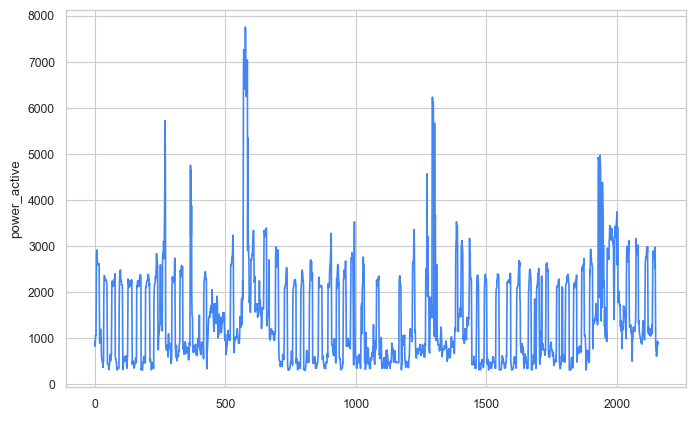

In [18]:
n = ((ONEDAY_MIN*60)//resampling_period)*3

sns.lineplot(x=np.arange(len(df[power_variable][:n])), 
             y=df[power_variable][:n])

## 
# Model

## Preprocess

### split train/validation

In [19]:
val_day = 24
oneday_sample = (ONEDAY_MIN*60)//resampling_period

split_index = df.shape[0] - (oneday_sample*val_day)

In [20]:
train = df[:split_index]
val = df[split_index:]

In [21]:
train.head()

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_id,weekday
0,2012-04-01 00:00:00,0.930,141.0,915.5,1061.0,1,6
1,2012-04-01 00:02:00,0.930,140.0,872.0,1019.5,1,6
2,2012-04-01 00:04:00,0.895,140.5,826.5,1073.5,1,6
3,2012-04-01 00:06:00,0.930,195.5,1064.5,1269.5,1,6
4,2012-04-01 00:08:00,0.930,187.0,1071.0,1238.5,1,6


In [22]:
val.head()

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_id,weekday
508320,2014-03-08 00:00:00,0.990,153.0,2839.5,2867.0,1,5
508321,2014-03-08 00:02:00,0.990,145.0,2897.0,2919.5,1,5
508322,2014-03-08 00:04:00,0.995,151.0,3301.5,3318.5,1,5
508323,2014-03-08 00:06:00,0.930,113.0,840.5,1021.5,1,5
508324,2014-03-08 00:08:00,0.920,118.0,792.5,984.5,1,5


In [23]:
train.shape, val.shape

((508320, 7), (17280, 7))

### preprocess time series data

In [24]:
power_variable = "power_active"

window_size = oneday_sample//24
output_size = 1

In [25]:
window_size

30

In [26]:
X_train, Y_train = preprocess_timeseries.windowing_arr_X_Y(train[power_variable], 
                                                           window_size, output_size)

In [27]:
X_val, Y_val = preprocess_timeseries.windowing_arr_X_Y(val[power_variable], 
                                                           window_size, output_size)

In [28]:
X_train.shape, Y_train.shape

((508290, 30), (508290, 1))

In [29]:
X_val.shape, Y_val.shape

((17250, 30), (17250, 1))

In [30]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [31]:
X_train.shape, X_val.shape

((508290, 30, 1), (17250, 30, 1))

## create model

In [32]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, n_epoch):
        self.n_epoch = n_epoch
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == 0 or (epoch+1)%self.n_epoch == 0:
            print(f"Epoch: {epoch+1}")
            for key, value in logs.items():
                print(f"{key}: {value:.4f}", end=" \t ")
            print()

In [33]:
model = Sequential()
model.add(Conv1D(24, kernel_size=5, input_shape=[None, 1], 
                 strides=1, padding="causal",
                 activation="relu"))
model.add(LSTM(window_size//2, return_sequences=False))
model.add(Dense(output_size))

In [34]:
optimizer = Adam(learning_rate=5e-3)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [ ]:
num_epochs = 3
batch_size = 16
hist = model.fit(X_train, Y_train, 
                 epochs=num_epochs, batch_size=batch_size, 
                 validation_data=(X_val, Y_val), verbose=1)

Epoch 1/3
31769/31769 [==============================] - 125s 4ms/step - loss: 653.3845 - val_loss: 654.9799
Epoch 2/3
31769/31769 [==============================] - 123s 4ms/step - loss: 548.6052 - val_loss: 654.9855
Epoch 3/3
18907/31769 [================>.............] - ETA: 48s - loss: 547.9012

In [ ]:
epochs = np.arange(1, num_epochs+1)

sns.lineplot(epochs, hist.history['loss'], label="loss")
sns.lineplot(epochs, hist.history['val_loss'], label="validation loss")

## Predict Validation set

In [ ]:
predicted = model.predict(X_val)

In [ ]:
time_x = np.arange(len(Y_val))

In [ ]:
sns.lineplot(time_x, Y_val.squeeze(), label="y val")
sns.lineplot(time_x, predicted.squeeze(), label="predicted y val")


plt.xlim([-5, oneday_sample*3])
plt.show()

In [ ]:
sns.lineplot(time_x, Y_val.squeeze(), label="y val")
sns.lineplot(time_x, predicted.squeeze(), label="predicted y val")


plt.xlim([-5, oneday_sample*1])
plt.show()